# Accountability through Model Reporting

<a href="https://colab.research.google.com/drive/1uN-dX1tW8N-SGtWXSEhcNtmB7P-2aGVA" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).

A model card is a document that provides information about a particular machine-learning model. It serves as a means of documenting and communicating various aspects of the model, including its intended use, performance characteristics, limitations, and potential ethical considerations.

This methodology was first proposed by [Mitchell et al.](https://arxiv.org/abs/1810.03993) in the article _[Model Cards for Model Reporting](https://arxiv.org/abs/1810.03993)_. Citing the authors:

> "_We hope this work encourages those releasing trained machine learning models to accompany model releases with similar detailed evaluation numbers and other relevant documentation._"

<img src="https://cdn2.iconfinder.com/data/icons/text-file-extension-field-outline-1/64/1_README-512.png" alt="drawing" height="200"/>

Source: [Iconfinder](https://www.iconfinder.com/).

Before writing a model card and documenting the development of a model, we need a model to demonstrate. We will use our smile detector, trained on this [notebook](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/fair_metrics_celeba.ipynb), as a study case for this tutorial.

> **Note: all models used in our tutorials can be found in the Hub. 🤗**

In [1]:
!pip install huggingface_hub -q

from huggingface_hub import hf_hub_download

# Download the pytorch model
hf_hub_download(repo_id="AiresPucrs/LeNNon-Smile-Detector",
                filename="LeNNon-Smile-Detector.pt",
                local_dir="./",
                repo_type="model"
                )

# Download the source implementation of the model's architecture
hf_hub_download(repo_id="AiresPucrs/LeNNon-Smile-Detector",
                filename="lennon.py",
                local_dir="./",
                repo_type="model"
                )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


LeNNon-Smile-Detector.pt:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

lennon.py:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

'./lennon.py'

Before continuing, let us first check our model is working as intended. We will be loading two sample images from our model's repo to test it.

> **Note: We must also import the `LeNNon` class from our lennon.py file, which implements this model's architecture.**

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

image_not_smiling.jpg:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

image_smiling.jpg:   0%|          | 0.00/3.04k [00:00<?, ?B/s]

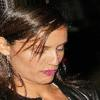

Not Smiling


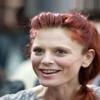

Smiling


In [2]:
import torch
from PIL import Image
from lennon import LeNNon
from torchvision import transforms
from IPython.display import display
from huggingface_hub import snapshot_download

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model an pass it to the proper device
model = torch.load('./LeNNon-Smile-Detector.pt')
model = model.to(device)
model.eval()

# Load two test images from the `AiresPucrs/LeNNon-Smile-Detector` repository
snapshot_download(repo_id="AiresPucrs/LeNNon-Smile-Detector",
                  repo_type="model",
                  allow_patterns="*.jpg",
                  local_dir="./"
                  )

# This `transform` object will transform our test images into proper tensors
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize the image to 100x100
    transforms.ToTensor(),
])

def inference(image_path):
  # preprocess the image
  image = Image.open(image_path)
  tensor = transform(image)
  tensor = tensor.to(device)

  # forward pass trough the model
  with torch.no_grad():
    outputs = model(tensor)

  # Get the class prediction
  _, predicted = torch.max(outputs.data, 1)

  # Display the image
  display(image)

  return print("Smiling" if predicted.item() > 0 else "Not Smiling")

inference("/content/image_not_smiling.jpg")
inference("/content/image_smiling.jpg")

Excellent, everything is working as intended. Now, we can start documenting the model card for our system. First, let us outline some basic information a model card should have.

> **Note: Platforms like Hugging Face incentivize the display of model cards and dataset cards for all objects hosted in the Hub. [Here](https://huggingface.co/docs/hub/model-cards) and [here](https://huggingface.co/docs/hub/datasets-cards), you can find examples of how to develop your own model and dataset cards.**

A typical model card may contain the following information:

1.  **Model Overview:**
    
    -   Name of the model
    -   Brief description of the model's purpose and functionality
    -   Details about the architecture and structure of the model
    -   Number of parameters, layers, and other relevant information
    -   Values of hyperparameters used during training
    -   Information about the optimization algorithm and learning rate

2.  **Intended Use:**
    
    -   The intended applications or use cases for the model
    -   Any specific user demographics or scenarios the model is designed for

3.  **Performance Metrics:**
    
    -   Evaluation metrics used to assess the model's performance
    -   Results of the model on various datasets or benchmarks

4.  **Training Data:**
    
    -   Description of the datasets used to train the model
    -   Any preprocessing or data augmentation techniques applied

5.  **Limitations:**
    
    -   Explicitly stated assumptions and limitations of the model
    -   Conditions under which the model is expected to perform well or poorly

6.  **References:**
    
    -   Citations or references to relevant papers, datasets, or external resources

First, let us write a general overview of our model. This should contain information to allow a user to understand the model's purpose quickly.

> **Note: Adding a "how to use" section to your model card is generally a good practice. In our example, we will be adding this to this first section.**

In [3]:
# We are using Markdown notation to write the sections of our model card

overview = """
# LeNNon-Smile-Detector

## Model Overview

The LeNNon-Smile-Detector is a convolutional neural network trained to detect the presence of a human smile in a facial image.

### Details

- **Size:** 2,566,506 parameters
- **Model type:** Convolutional neural network
- **Optimizer**: `torch.optim.Adam` with a learning rate of 0.001
- **Number of Epochs:** 20
- **Batch Size:** 256
- **Hardware:** Tesla V4
- **Emissions:** Not measured
- **Total Energy Consumption:** Not measured

### How to Use

To run inference on this model, you can use the following code snippet:

```python
import torch
from PIL import Image
from lennon import LeNNon
from torchvision import transforms
from huggingface_hub import hf_hub_download

# Download the pytorch model
hf_hub_download(repo_id="AiresPucrs/LeNNon-Smile-Detector",
                filename="LeNNon-Smile-Detector.pt",
                local_dir="./",
                repo_type="model"
                )

# Download the source implementation of the model's architecture
hf_hub_download(repo_id="AiresPucrs/LeNNon-Smile-Detector",
                filename="lennon.py",
                local_dir="./",
                repo_type="model"
                )

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model an pass it to the proper device
model = torch.load('./LeNNon-Smile-Detector.pt')
model = model.to(device)
model.eval()

# This `transform` object will transform our test images into proper tensors
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize the image to 100x100
    transforms.ToTensor(),
])

image_path = "your_image_path_here"

# Open and preprocess he image
image = Image.open(image_path)
tensor = transform(image)
tensor = tensor.to(device)

# forward pass trough the model
with torch.no_grad():

  outputs = model(tensor)

# Get the class prediction
_, predicted = torch.max(outputs.data, 1)

print("Smiling" if predicted.item() > 0 else "Not Smiling")
```
"""

> **Note: Even though it is not reported above, measuring your energy consumption while training ML models is a good practice. You can use libraries like [CodeCarbon](https://github.com/mlco2/codecarbon) for this. We have a tutorial on how to do this [here](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Accountability/CO2-Emission-tracking/emission_tracker.ipynb).**

In the intended use section, we can set the usage scope for our model, specifying what the model was and was not made for.

In [4]:
intended_use = """
## Intended Use

This model was created for research purposes only. Specifically, it was designed to explore discriminatory biases present in a subset of the CelebA dataset (the [CelebA-Smiles](https://huggingface.co/datasets/AiresPucrs/CelebA-Smiles)). We do not recommend any application of this model outside this scope.

"""

We can specify how the model was evaluated and its results in the metrics sections.

> **Note: These results come from this [tutorial](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/fair_metrics_celeba.ipynb).**

In [5]:
metrics = """
## Performance Metrics

The model achieved an accuracy of 97% in a test set split containing 5000 images from the [CelebA-Smiles](https://huggingface.co/datasets/AiresPucrs/CelebA-Smiles).
"""

In the training data section, we specify the dataset and preprocessing steps taken before training our model.

**Note: Datasets can also have their own [specification cards](https://huggingface.co/datasets/AiresPucrs/CelebA-Smiles).**

In [6]:
training_data = """
## Training Data

The model was trained on a subset of the [CelebA dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset), i.e., CelebA-Smiles.

CelebA-Smiles contains 50K images. 25K of smiling faces, and 25K of non smiling faces.

Images on the CelebA-Smiles were resized to 100 x 100 pixels before training the model. For more details on the features contained in the CelebA-Smiles dataset, check its [dataset card](https://huggingface.co/datasets/AiresPucrs/CelebA-Smiles).
"""

In the limitations section, we make explicit all concerns and problems we could detect during the development and exploration of our model.

> **Note: Nowadays, it is common for [big model releases](https://arxiv.org/abs/2307.09288) to be accompanied by broader impact analysis, which explores the inherent ethical limitations of a given ML model.**

In [7]:
limitations = """
## Limitations

We performed a simple fairness analysis of our model regarding the sensitive attribute **age**.

According to our analysis, the model has no discriminatory bias regarding this feature. Results can be found [here](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/fair_metrics_celeba.ipynb).

Other possible biases were not investigated, but further investigations are likely given that other sensitive attributes present in the training dataset are available.

In conclusion, we do not recommend using this model in real-world applications. It was solely developed for academic and educational purposes.
"""

Finally, in the last two sections, we inform the user how they should reference this model and the license associated with its use.

> **Note: Adding a `LICENSE` file to any publicly available software is good practice. You can find models of how to make licenses in the links below.**

- **[MIT License](https://opensource.org/license/MIT/)**
- **[Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0.html)**
- **[Creative Commons 4.0](https://creativecommons.org/version4/)**
- **[Responsible AI Licenses](https://www.licenses.ai/)**

In [8]:
reference_and_license = """
## Cite as

```latex
@misc{teenytinycastle,
    doi = {10.5281/zenodo.7112065},
    url = {https://github.com/Nkluge-correa/TeenyTinyCastle},
    author = {Nicholas Kluge Corr{\^e}a},
    title = {Teeny-Tiny Castle},
    year = {2024},
    publisher = {GitHub},
    journal = {GitHub repository},
}
```

## License

This model is licensed under the Apache License, Version 2.0. See the [LICENSE](LICENSE) file for more details.

"""

In the Hugging Face Hub, adding metadata to a model card is also standard. So, since our model is hosted on the Hub, we all have this information, too.

> **Note: For more information on how to add your metadata, visit this [link](https://huggingface.co/docs/hub/model-cards#using-the-metadata-ui).**

In [9]:
metadata= """---
license: apache-2.0
language:
- en
datasets:
- AiresPucrs/CelebA-Smiles
metrics:
- accuracy
tags:
- image-classification
---
"""

Now, we can add everything to a README.md file!

In [10]:
from IPython.display import display, Markdown

model_card = metadata + overview + intended_use + metrics + training_data + limitations + reference_and_license

display(Markdown(model_card))

# Save the model card as a README file
with open('README.md', 'w+', encoding='utf8') as fp:
    fp.write(model_card)

---
license: apache-2.0
language:
- en
datasets:
- AiresPucrs/CelebA-Smiles
metrics:
- accuracy
tags:
- image-classification
---

# LeNNon-Smile-Detector

## Model Overview

The LeNNon-Smile-Detector is a convolutional neural network trained to detect the presence of a human smile in a facial image.

### Details

- **Size:** 2,566,506 parameters
- **Model type:** Convolutional neural network
- **Optimizer**: `torch.optim.Adam` with a learning rate of 0.001
- **Number of Epochs:** 20
- **Batch Size:** 256
- **Hardware:** Tesla V4
- **Emissions:** Not measured
- **Total Energy Consumption:** Not measured

### How to Use

To run inference on this model, you can use the following code snippet:

```python
import torch
from PIL import Image
from lennon import LeNNon
from torchvision import transforms
from huggingface_hub import hf_hub_download

# Download the pytorch model
hf_hub_download(repo_id="AiresPucrs/LeNNon-Smile-Detector",
                filename="LeNNon-Smile-Detector.pt",
                local_dir="./",
                repo_type="model"
                )

# Download the source implementation of the model's architecture
hf_hub_download(repo_id="AiresPucrs/LeNNon-Smile-Detector",
                filename="lennon.py",
                local_dir="./",
                repo_type="model"
                )

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model an pass it to the proper device
model = torch.load('./LeNNon-Smile-Detector.pt')
model = model.to(device)
model.eval()

# This `transform` object will transform our test images into proper tensors
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize the image to 100x100
    transforms.ToTensor(),
])

image_path = "your_image_path_here"

# Open and preprocess he image
image = Image.open(image_path)
tensor = transform(image)
tensor = tensor.to(device)

# forward pass trough the model
with torch.no_grad():

  outputs = model(tensor)

# Get the class prediction
_, predicted = torch.max(outputs.data, 1)

print("Smiling" if predicted.item() > 0 else "Not Smiling")
```

## Intended Use

This model was created for research purposes only. Specifically, it was designed to explore discriminatory biases present in a subset of the CelebA dataset (the [CelebA-Smiles](https://huggingface.co/datasets/AiresPucrs/CelebA-Smiles)). We do not recommend any application of this model outside this scope.


## Performance Metrics

The model achieved an accuracy of 97% in a test set split containing 5000 images from the [CelebA-Smiles](https://huggingface.co/datasets/AiresPucrs/CelebA-Smiles).

## Training Data

The model was trained on a subset of the [CelebA dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset), i.e., CelebA-Smiles.

CelebA-Smiles contains 50K images. 25K of smiling faces, and 25K of non smiling faces.

Images on the CelebA-Smiles were resized to 100 x 100 pixels before training the model. For more details on the features contained in the CelebA-Smiles dataset, check its [dataset card](https://huggingface.co/datasets/AiresPucrs/CelebA-Smiles).

## Limitations

We performed a simple fairness analysis of our model regarding the sensitive attribute **age**.

According to our analysis, the model has no discriminatory bias regarding this feature. Results can be found [here](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/fair_metrics_celeba.ipynb).

Other possible biases were not investigated, but further investigations are likely given that other sensitive attributes present in the training dataset are available.

In conclusion, we do not recommend using this model in real-world applications. It was solely developed for academic and educational purposes.

## Cite as

```latex
@misc{teenytinycastle,
    doi = {10.5281/zenodo.7112065},
    url = {https://github.com/Nkluge-correa/TeenyTinyCastle},
    author = {Nicholas Kluge Corr{\^e}a},
    title = {Teeny-Tiny Castle},
    year = {2024},
    publisher = {GitHub},
    journal = {GitHub repository},
}
```

## License

This model is licensed under the Apache License, Version 2.0. See the [LICENSE](LICENSE) file for more details.



Since we are using the Hugging Face Hub to host our models, we can push our model card as a README.md file, and all is done.

In [11]:
from huggingface_hub import HfApi

api = HfApi(token="your_token_here")

api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo=f"README.md",
    repo_id="AiresPucrs/LeNNon-Smile-Detector",
)


CommitInfo(commit_url='https://huggingface.co/AiresPucrs/LeNNon-Smile-Detector/commit/86a25408fd0f1acd808e7fc5e01a724df272292b', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='86a25408fd0f1acd808e7fc5e01a724df272292b', pr_url=None, pr_revision=None, pr_num=None)

Model Cards are valuable tools for introducing a culture of transparency and responsibility in the AI community.

----

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).
